Created visualization of initial particle state (t=0)
Created visualization with 6 highlighted trajectories over the last 200 time steps
Created visualization at time step 200
Created visualization at time step 400
Created visualization at time step 600
Created visualization at time step 800
Created visualization at time step 1000
Created visualization at time step 1200


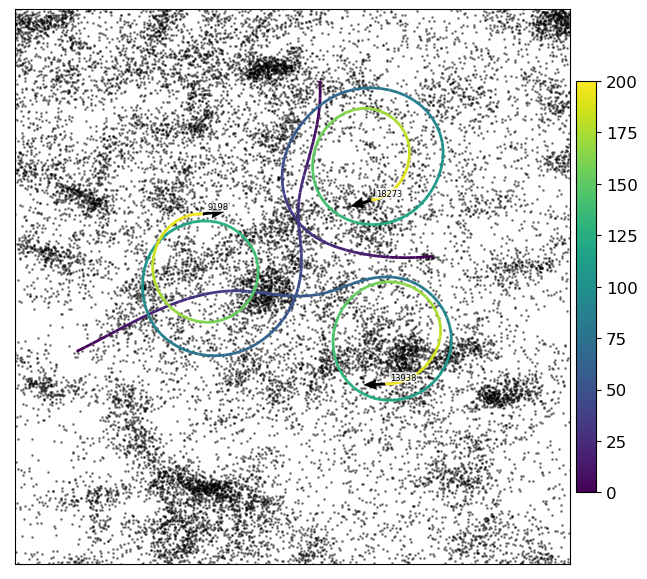

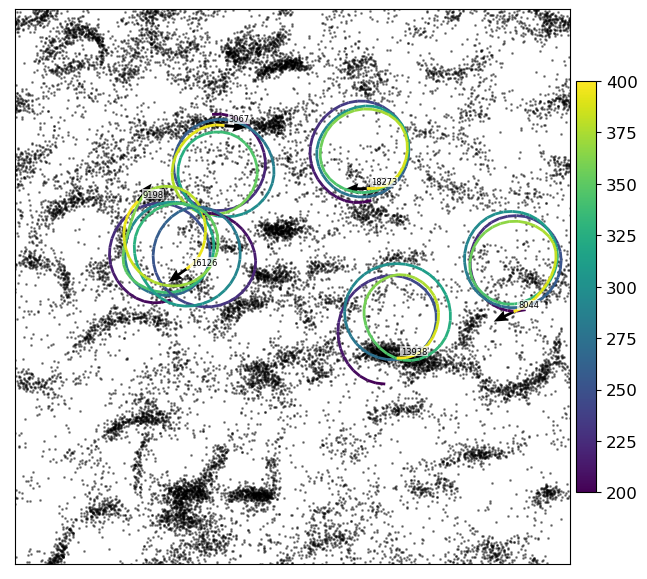

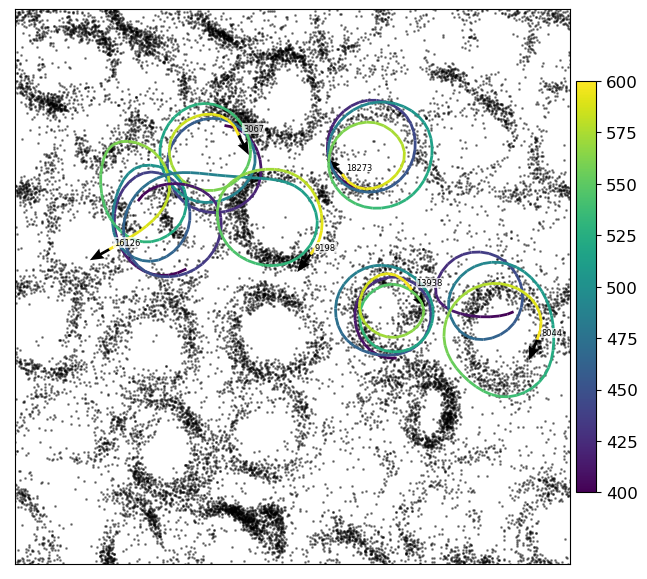

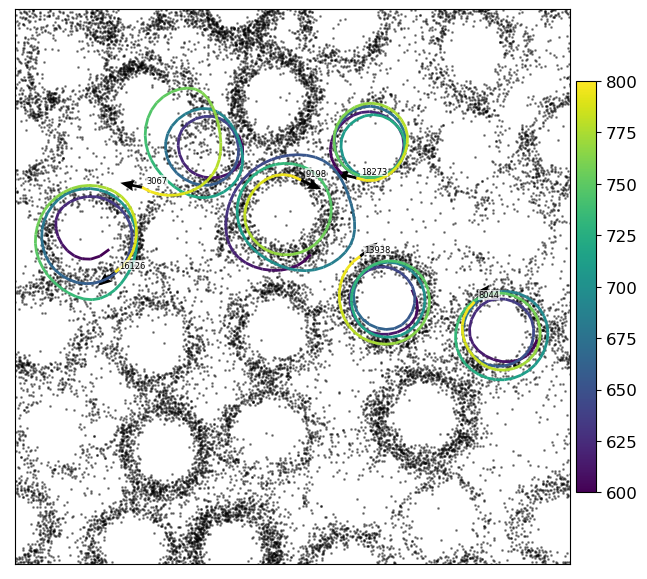

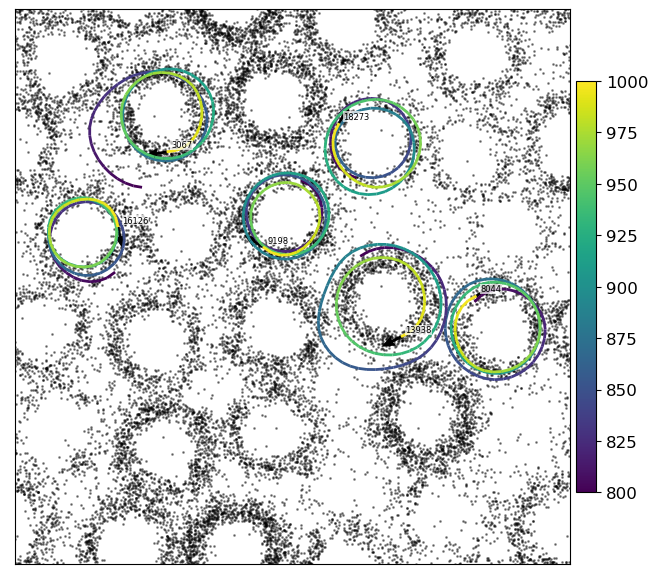

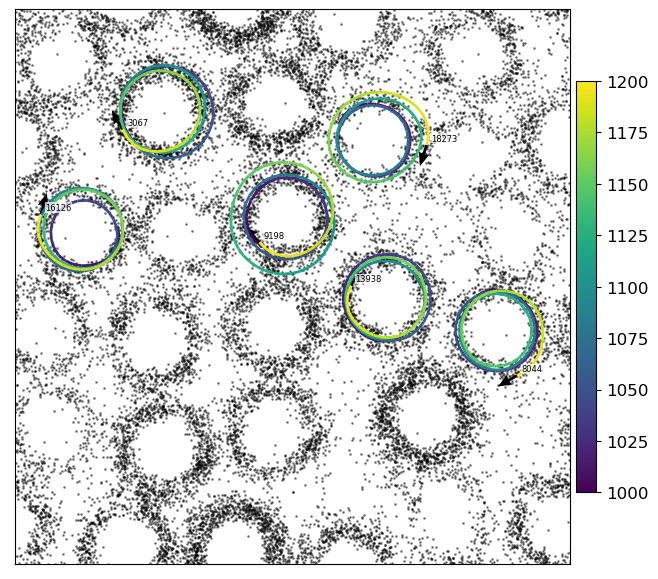

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.collections import LineCollection
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors
import random

# Find the data files
part_file = glob.glob("*.csv")[0]

# Load data
particles_df = pd.read_csv(part_file)

# Get system size from particles data
L = 64  # This should match the L parameter in the simulation

def plot_particles_with_trajectories(particles_df, selected_particle_ids, time_window, L):
    """
    Plot all particles as a scatter plot with highlighted trajectories for selected particles
    
    Parameters:
    - particles_df: DataFrame containing particle data
    - selected_particle_ids: List of specific particle IDs to track with trajectories
    - time_window: Number of time steps to show in the trajectory
    - L: Domain size
    """
    # Get the latest time step in the data
    max_time = particles_df["time_step"].max()
    
    # Get time steps for the trajectory (from t-time_window to t)
    trajectory_times = np.arange(max(0, max_time - time_window), max_time + 1)
    
    # Get all particles at the final time step for the background scatter
    final_particles = particles_df[particles_df["time_step"] == max_time]
    
    # Create figure with minimal margins
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot all particles as a background scatter
    ax.scatter(
        final_particles['x'], 
        final_particles['y'], 
        color='black', 
        alpha=0.4, 
        s=1
    )
    
    # Set up colormap for trajectory time evolution
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(trajectory_times), vmax=max(trajectory_times))
    
    # Create a color array for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Track each selected particle
    for i, particle_id in enumerate(selected_particle_ids):
        # Get data for this particle within the time window
        particle_data = particles_df[(particles_df['particle_id'] == particle_id) & 
                                    (particles_df['time_step'].isin(trajectory_times))]
        
        if len(particle_data) < 2:  # Need at least 2 points for trajectory
            continue
            
        # Sort by time step to ensure chronological order
        particle_data = particle_data.sort_values('time_step')
        
        # Extract coordinates and time data
        t_data = np.array(particle_data['time_step'])
        x_data = np.array(particle_data['x'])
        y_data = np.array(particle_data['y'])
        
        # Check if this particle crosses a boundary
        crosses_boundary = False
        for i in range(1, len(x_data)):
            dx = abs(x_data[i] - x_data[i-1])
            dy = abs(y_data[i] - y_data[i-1])
            if dx > L/2 or dy > L/2:
                crosses_boundary = True
                break
        
        if crosses_boundary:
            continue  # Skip this particle
            
        # Create more points for smooth interpolation
        t_fine = np.linspace(t_data.min(), t_data.max(), 100)
        
        # Cubic spline interpolation
        cs_x = CubicSpline(t_data, x_data)
        cs_y = CubicSpline(t_data, y_data)
        
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        
        # Create colored segments based on time
        points = np.array([x_fine, y_fine]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a LineCollection for efficient colored line plotting
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(t_fine[:-1])  # Set colors based on time
        lc.set_linewidth(2)
        ax.add_collection(lc)
        
        # Add quiver for the last time step
        last_point = particle_data[particle_data['time_step'] == max_time]
        if not last_point.empty:
            x, y, theta = last_point[['x', 'y', 'theta']].values[0]
            dx, dy = np.cos(theta), np.sin(theta)
            ax.quiver(x, y, dx, dy, color='black', scale=25, width=0.005, headwidth=4, headlength=5)
            
            # Add text label for the particle ID near the end point - smaller font size
            ax.text(x + 0.5, y + 0.5, f"{particle_id}", fontsize=6, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))
    
    # Add a smaller colorbar
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
    cbar.ax.tick_params(labelsize=12)
    
    # Set plot limits and remove all labels
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    
    # Remove labels, ticks, etc.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    # Maximize the plot area
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    
    return fig, ax

def plot_initial_particles(particles_df, L):
    """
    Plot just the initial state (t=0) of all particles
    
    Parameters:
    - particles_df: DataFrame containing particle data
    - L: Domain size
    """
    # Get particles at t=0
    initial_particles = particles_df[particles_df["time_step"] == 0]
    
    # Create figure with minimal margins
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot all particles as a scatter plot
    ax.scatter(
        initial_particles['x'], 
        initial_particles['y'], 
        color='black', 
        alpha=0.4, 
        s=1
    )
    
    # Set plot limits and remove all labels
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    
    # Remove labels, ticks, etc.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    # Maximize the plot area
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    
    return fig, ax

# Number of trajectories to show
num_trajectories = 6

# Get unique particle IDs
unique_particle_ids = particles_df["particle_id"].unique()

# Randomly select particles for trajectories
random.seed(221)  # For reproducibility
selected_particles = random.sample(list(unique_particle_ids), num_trajectories)

# Set the time window (last 200 time steps)
time_window = 200

# Create and save a plot of the initial state (t=0)
fig, ax = plot_initial_particles(particles_df, L)
plt.savefig("particles_initial_state.png", dpi=300, bbox_inches='tight', pad_inches=0)
print("Created visualization of initial particle state (t=0)")
plt.close(fig)

# Create and save the plot with trajectories
fig, ax = plot_particles_with_trajectories(particles_df, selected_particles, time_window, L)
plt.savefig("particles_with_trajectories.png", dpi=300, bbox_inches='tight', pad_inches=0)
print(f"Created visualization with {num_trajectories} highlighted trajectories over the last {time_window} time steps")
plt.close(fig)

# Create an animation-like series of plots at different time points
time_points = [200, 400, 600, 800, 1000, 1200]

for time_point in time_points:
    # Skip time points that exceed our data
    max_time = particles_df["time_step"].max()
    if time_point > max_time:
        continue
        
    # Filter data up to this time point
    current_df = particles_df[particles_df["time_step"] <= time_point]
    
    # Find the actual max time in this filtered dataset
    actual_max_time = current_df["time_step"].max()
    
    # Create the plot
    fig, ax = plot_particles_with_trajectories(current_df, selected_particles, time_window, L)
    plt.savefig(f"particles_with_trajectories_t{actual_max_time}.png", dpi=300, bbox_inches='tight', pad_inches=0)
    print(f"Created visualization at time step {actual_max_time}")
    # plt.close(fig)

Created visualization of initial particle state (t=0)
Created visualization with 6 highlighted trajectories over the last 200 time steps
Created visualization at time step 200
Created visualization at time step 400
Created visualization at time step 600
Created visualization at time step 800
Created visualization at time step 1000
Created visualization at time step 1200


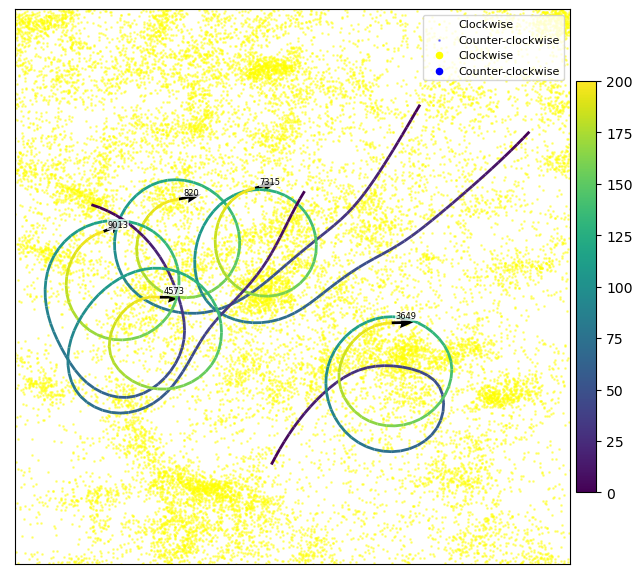

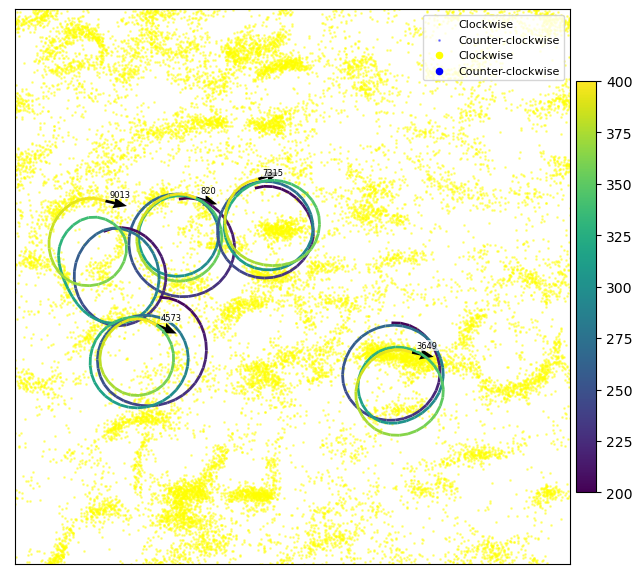

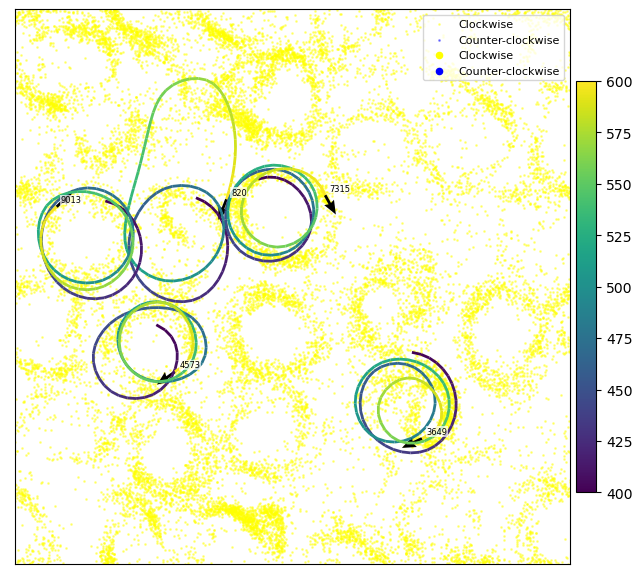

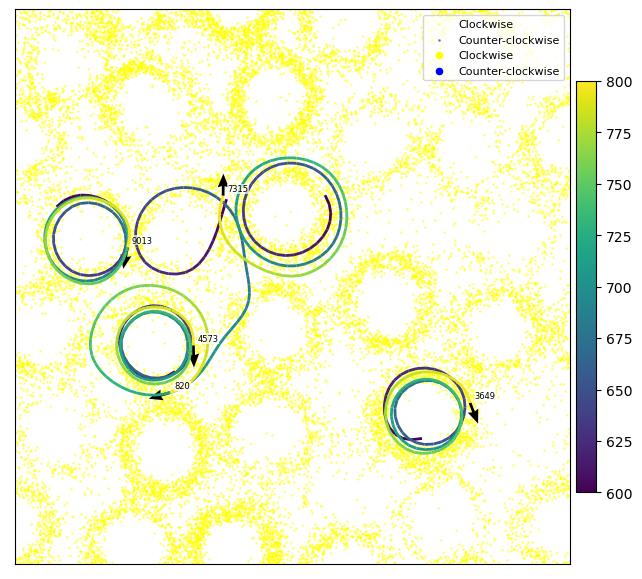

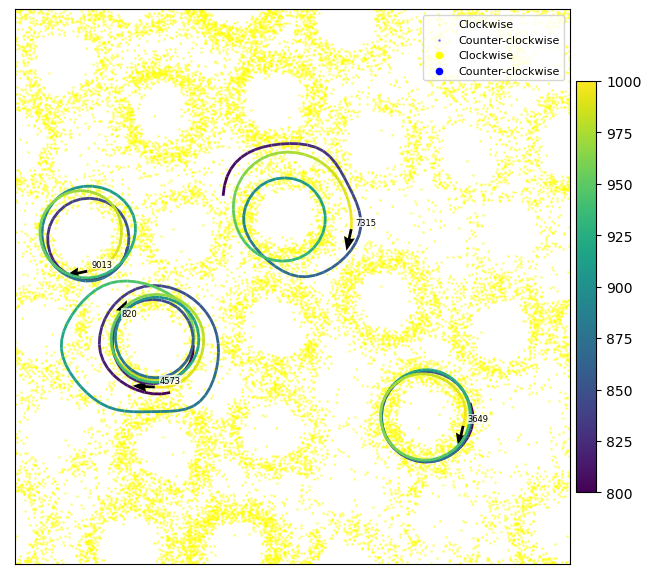

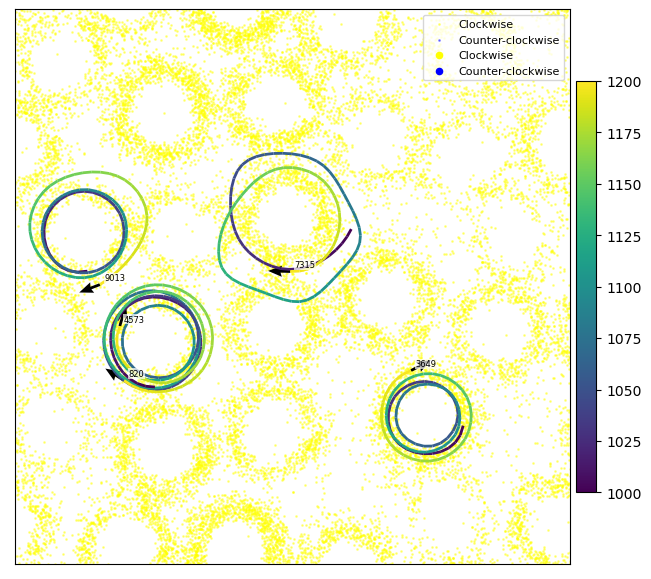

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.collections import LineCollection
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors
import random

# Find the data files
part_file = glob.glob("*.csv")[0]

# Load data
particles_df = pd.read_csv(part_file)

# Get system size from particles data
L = 64  # This should match the L parameter in the simulation

def plot_particles_with_trajectories(particles_df, selected_particle_ids, time_window, L):
    """
    Plot all particles as a scatter plot with highlighted trajectories for selected particles
    Particles are colored based on their direction: yellow for clockwise (negative omega), blue for counter-clockwise (positive omega)
    
    Parameters:
    - particles_df: DataFrame containing particle data
    - selected_particle_ids: List of specific particle IDs to track with trajectories
    - time_window: Number of time steps to show in the trajectory
    - L: Domain size
    """
    # Get the latest time step in the data
    max_time = particles_df["time_step"].max()
    
    # Get time steps for the trajectory (from t-time_window to t)
    trajectory_times = np.arange(max(0, max_time - time_window), max_time + 1)
    
    # Get all particles at the final time step for the background scatter
    final_particles = particles_df[particles_df["time_step"] == max_time]
    
    # Create figure with minimal margins
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot particles based on their omega value
    # Negative omega (clockwise) particles will be yellow
    clockwise_particles = final_particles[final_particles['omega'] < 0]
    # Positive omega (counter-clockwise) particles will be blue
    counter_clockwise_particles = final_particles[final_particles['omega'] >= 0]
    
    # Plot clockwise particles (yellow)
    ax.scatter(
        clockwise_particles['x'], 
        clockwise_particles['y'], 
        color='yellow', 
        alpha=0.4, 
        s=1,
        label='Clockwise'
    )
    
    # Plot counter-clockwise particles (blue)
    ax.scatter(
        counter_clockwise_particles['x'], 
        counter_clockwise_particles['y'], 
        color='blue', 
        alpha=0.4, 
        s=1,
        label='Counter-clockwise'
    )
    
    # Set up colormap for trajectory time evolution
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(trajectory_times), vmax=max(trajectory_times))
    
    # Create a color array for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Track each selected particle
    for i, particle_id in enumerate(selected_particle_ids):
        # Get data for this particle within the time window
        particle_data = particles_df[(particles_df['particle_id'] == particle_id) & 
                                    (particles_df['time_step'].isin(trajectory_times))]
        
        if len(particle_data) < 2:  # Need at least 2 points for trajectory
            continue
            
        # Sort by time step to ensure chronological order
        particle_data = particle_data.sort_values('time_step')
        
        # Extract coordinates and time data
        t_data = np.array(particle_data['time_step'])
        x_data = np.array(particle_data['x'])
        y_data = np.array(particle_data['y'])
        
        # Check if this particle crosses a boundary
        crosses_boundary = False
        for i in range(1, len(x_data)):
            dx = abs(x_data[i] - x_data[i-1])
            dy = abs(y_data[i] - y_data[i-1])
            if dx > L/2 or dy > L/2:
                crosses_boundary = True
                break
        
        if crosses_boundary:
            continue  # Skip this particle
            
        # Create more points for smooth interpolation
        t_fine = np.linspace(t_data.min(), t_data.max(), 100)
        
        # Cubic spline interpolation
        cs_x = CubicSpline(t_data, x_data)
        cs_y = CubicSpline(t_data, y_data)
        
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        
        # Create colored segments based on time
        points = np.array([x_fine, y_fine]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a LineCollection for efficient colored line plotting
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(t_fine[:-1])  # Set colors based on time
        lc.set_linewidth(2)
        ax.add_collection(lc)
        
        # Add quiver for the last time step
        last_point = particle_data[particle_data['time_step'] == max_time]
        if not last_point.empty:
            x, y, theta, omega = last_point[['x', 'y', 'theta', 'omega']].values[0]
            dx, dy = np.cos(theta), np.sin(theta)
            # Set the color of the quiver based on the rotation direction
            quiver_color = 'black'
            ax.quiver(x, y, dx, dy, color=quiver_color, scale=25, width=0.005, headwidth=4, headlength=5)
            
            # Add text label for the particle ID near the end point - smaller font size
            ax.text(x + 0.5, y + 0.5, f"{particle_id}", fontsize=6, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))
    
    # Add a smaller colorbar with larger font size
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
    cbar.ax.tick_params(labelsize=10)  # Increase font size for tick labels
    
    # Add a legend for the clockwise/counter-clockwise particles
    # Create dummy scatter plots for the legend with bigger points
    ax.scatter([], [], color='yellow', s=20, label='Clockwise')
    ax.scatter([], [], color='blue', s=20, label='Counter-clockwise')
    ax.legend(loc='upper right', fontsize=8)
    
    # Set plot limits and remove all labels
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    
    # Remove labels, ticks, etc.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    # Maximize the plot area
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    
    return fig, ax

def plot_initial_particles(particles_df, L):
    """
    Plot just the initial state (t=0) of all particles
    Particles are colored based on their direction: yellow for clockwise (negative omega), blue for counter-clockwise (positive omega)
    
    Parameters:
    - particles_df: DataFrame containing particle data
    - L: Domain size
    """
    # Get particles at t=0
    initial_particles = particles_df[particles_df["time_step"] == 0]
    
    # Create figure with minimal margins
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Separate particles based on their omega value
    clockwise_particles = initial_particles[initial_particles['omega'] < 0]
    counter_clockwise_particles = initial_particles[initial_particles['omega'] >= 0]
    
    # Plot clockwise particles (yellow)
    ax.scatter(
        clockwise_particles['x'], 
        clockwise_particles['y'], 
        color='yellow', 
        alpha=0.4, 
        s=1,
        label='Clockwise'
    )
    
    # Plot counter-clockwise particles (blue)
    ax.scatter(
        counter_clockwise_particles['x'], 
        counter_clockwise_particles['y'], 
        color='blue', 
        alpha=0.4, 
        s=1,
        label='Counter-clockwise'
    )
    
    # Add a legend
    ax.scatter([], [], color='yellow', s=20, label='Clockwise')
    ax.scatter([], [], color='blue', s=20, label='Counter-clockwise')
    ax.legend(loc='upper right', fontsize=8)
    
    # Set plot limits and remove all labels
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    
    # Remove labels, ticks, etc.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    # Maximize the plot area
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    
    return fig, ax

# Number of trajectories to show
num_trajectories = 6

# Get unique particle IDs
unique_particle_ids = particles_df["particle_id"].unique()

# Randomly select particles for trajectories
random.seed(42)  # For reproducibility
selected_particles = random.sample(list(unique_particle_ids), num_trajectories)

# Set the time window (last 200 time steps)
time_window = 200

# Create and save a plot of the initial state (t=0)
fig, ax = plot_initial_particles(particles_df, L)
plt.savefig("particles_initial_state.png", dpi=300, bbox_inches='tight', pad_inches=0)
print("Created visualization of initial particle state (t=0)")
plt.close(fig)

# Create and save the plot with trajectories
fig, ax = plot_particles_with_trajectories(particles_df, selected_particles, time_window, L)
plt.savefig("particles_with_trajectories.png", dpi=300, bbox_inches='tight', pad_inches=0)
print(f"Created visualization with {num_trajectories} highlighted trajectories over the last {time_window} time steps")
plt.close(fig)

# Create an animation-like series of plots at different time points
time_points = [200, 400, 600, 800, 1000, 1200]

for time_point in time_points:
    # Skip time points that exceed our data
    max_time = particles_df["time_step"].max()
    if time_point > max_time:
        continue
        
    # Filter data up to this time point
    current_df = particles_df[particles_df["time_step"] <= time_point]
    
    # Find the actual max time in this filtered dataset
    actual_max_time = current_df["time_step"].max()
    
    # Create the plot
    fig, ax = plot_particles_with_trajectories(current_df, selected_particles, time_window, L)
    plt.savefig(f"particles_with_trajectories_t{actual_max_time}.png", dpi=300, bbox_inches='tight', pad_inches=0)
    print(f"Created visualization at time step {actual_max_time}")
    # plt.close(fig)

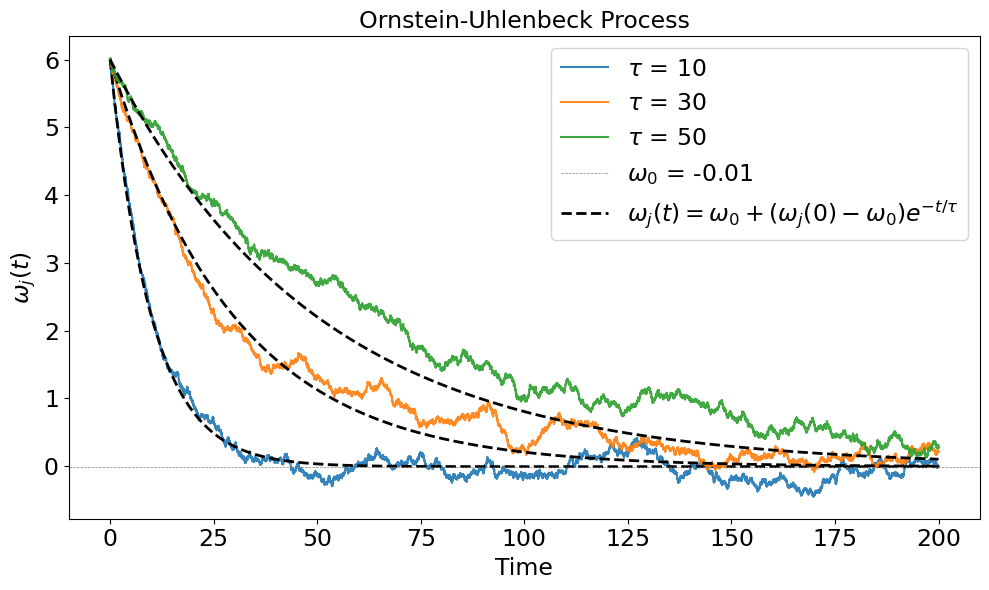

In [3]:
# Parameters
omega_0 = -0.01
taus = [10, 30, 50]  # Different relaxation times
sigma = 0.07         # Noise strength
T = 200              # Total time
dt = 0.01            # Time step
N = int(T / dt)      # Number of time steps
t = np.linspace(0, T, N)  # Time array
omega_init = 6

# Initialize plot
plt.figure(figsize=(10, 6))
analytical_label_plotted = False  # Flag to control label display

for tau in taus:
    # Initialize arrays
    omega_stochastic = np.zeros(N)
    omega_analytical = omega_0 + (omega_init - omega_0) * np.exp(-t / tau)

    # Set initial condition
    omega_stochastic[0] = omega_init

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian increment
        drift = - (1 / tau) * (omega_stochastic[i-1] - omega_0)
        omega_stochastic[i] = omega_stochastic[i-1] + drift * dt + sigma * dW

    # Plot stochastic simulation (faded)
    plt.plot(t, omega_stochastic, alpha=0.9, label=f"$\\tau$ = {tau}", linewidth=1.5)

    # Plot analytical solution with label only once
    if not analytical_label_plotted:
        analytical_plot = plt.plot(
            t, omega_analytical, color='black', linewidth=2, linestyle='--',
            label=r"$\omega_j(t) = \omega_0 + (\omega_j(0) - \omega_0)e^{-t/\tau}$"
        )
        analytical_label_plotted = True
    else:
        plt.plot(t, omega_analytical, color='black', linewidth=2, linestyle='--')

# Add horizontal line for omega_0
omega0_line = plt.axhline(
    omega_0, color='gray', linestyle='--',
    label=f"$\\omega_0$ = {omega_0}", linewidth=0.5
)

# Plot formatting
plt.title("Ornstein-Uhlenbeck Process", fontsize=17)
plt.xlabel("Time", fontsize=17)
plt.ylabel(r"$\omega_j(t)$", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
# Sort legend: stochastic first, then omega_0 line, then analytical
sorted_handles_labels = sorted(
    zip(handles, labels),
    key=lambda x: {
        r"$\omega_j(t) = \omega_0 + (\omega_j(0) - \omega_0)e^{-t/\tau}$": 2,
        f"$\\omega_0$ = {omega_0}": 1
    }.get(x[1], 0)  # default priority 0 for τ labels
)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels, loc='upper right', fontsize=17)

plt.tight_layout()
plt.savefig("modified_ou_process.png", dpi=300)
